In [20]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
import sys
sys.path.insert(0, '../')

# from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic

# import detectron2
# from detectron2.utils.logger import setup_logger

# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
# from detectron2 import model_zoo
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog
# from livecell_tracker.segment.detectron_utils import gen_cfg

# from livecell_tracker.segment.detectron_utils import (
#     segment_detectron_wrapper,
#     segment_images_by_detectron,
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
# )
# from livecell_tracker.segment.detectron_utils import (
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
#     segment_images_by_detectron,
#     segment_single_img_by_detectron_wrapper,
# )


## Loading single cells from existing mask files

```LiveCellImageDataset, SingleCellImageDataset``` from livecell_tracker.core.datasets allow users to load images with ease, without reading directly into memories.  
In `mask_dataset_path` please make sure that the sorted (alphabetically) file names correspond to the order of times.
 Note that the sorted mechanism provided is simply sort the url (file name) list according to string value. Please note that without proper left trailing zeroes, the order of final times may be incorrect. E.g. string  `T10` (10th file) is less than string `T2`. If you have your customized file patterns, please provide `LiveCellImageDataset` with a `time2url` dictionary to provide necessary time information mapped to file locations for reading time-lapsed data.
`SingleCellImageDataset` takes a single image from the memory and makes it a single time point dataset, which can be handy when you would like to process imaging datasets. 

In [21]:
dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

# dataset_dir_path = Path(
#     "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
# )

# mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")

In [22]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
mask_dataset.time2url

3 png img file paths loaded;


{0: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif.png',
 1: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif.png',
 2: '../datasets/test_data_STAV-A549/mask_data/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif.png'}

In [23]:
time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")
# dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

Check if the `time2url` mapping is correct

In [24]:
dic_dataset.time2url

{0: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif',
 1: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif',
 2: '../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif'}

### Convert label masks to single objects

In [25]:
from skimage.measure import regionprops
from livecell_tracker.segment.utils import prep_scs_from_mask_dataset
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


In [26]:
for sc in single_cells:
    assert sc.mask_dataset

In [27]:
# for testing
# single_cells = single_cells[:10]

In [28]:
len(single_cells)

42

In [29]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

In [30]:
for time in single_cells_by_time:
    print(time, len(single_cells_by_time[time]))

2 15
1 14
0 13


### Visualize one single cell

<Axes: >

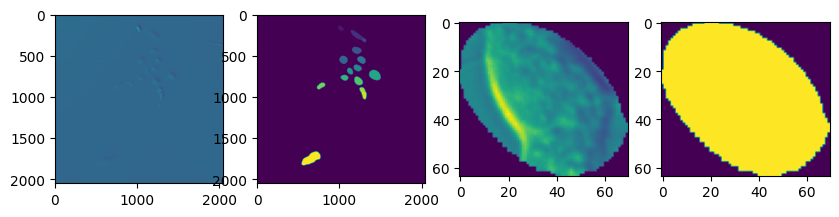

In [31]:
sc = single_cells[0]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
sc.show(ax=axes[0])
sc.show_mask(ax=axes[1])
sc.show_contour_img(ax=axes[2])
sc.show_contour_mask(ax=axes[3])

array([<Axes: title={'center': 'img'}>, <Axes: title={'center': 'mask'}>,
       <Axes: title={'center': 'contour_img'}>,
       <Axes: title={'center': 'contour_mask'}>,
       <Axes: title={'center': 'label_crop'}>,
       <Axes: title={'center': 'img_crop'}>], dtype=object)

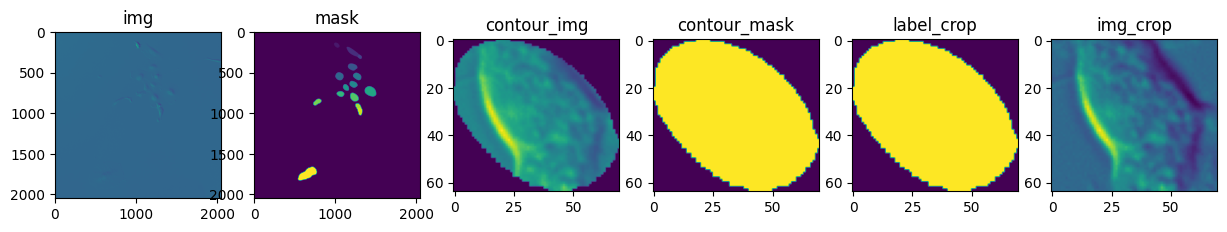

In [33]:
sc.show_panel(figsize=(15, 5))

### Preprocess cell image
apply `normalize_img_to_uint8` to the original image, and apply background correction algorithms `correct_background_bisplrep` and `correct_background_median_gamma` to a single cell.

In [40]:
from livecell_tracker.preprocess.correct_bg import correct_background_bisplrep, correct_background_median_gamma
from livecell_tracker.preprocess.utils import normalize_img_to_uint8
import numpy as np
import scipy
import scipy.interpolate as interp
from skimage import exposure, filters, morphology

sc = single_cells[0].copy()

padding_size = 30
# sc.show(crop=True)
sc_img = sc.get_img_crop(padding=padding_size)
original_sc = sc_img

bisplrep_sc_img = normalize_img_to_uint8(sc_img)
bisplrep_sc_img = correct_background_bisplrep(sc_img, sample_step=5, s=1e20)

gamma_sc_img = sc.get_img_crop(padding=padding_size)
gamma_sc_img = normalize_img_to_uint8(sc_img)
gamma_sc_img = correct_background_median_gamma(sc_img, disk_size=2)

TypeError: median() got an unexpected keyword argument 'selem'

Visualize bg correction results

Text(0.5, 1.0, 'corrected: gamma correction')

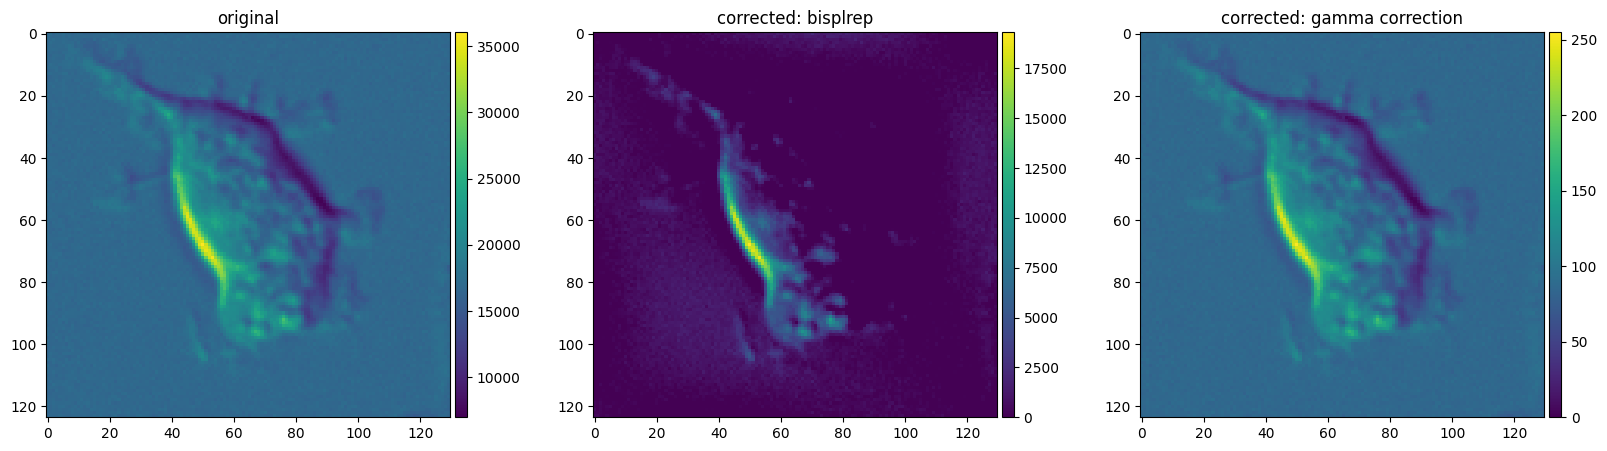

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, ax, fig):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
im = axes[0].imshow(original_sc)
# show colorbar
add_colorbar(im, axes[0], fig)
axes[0].set_title("original")

im = axes[1].imshow(bisplrep_sc_img)
add_colorbar(im, axes[1], fig)
axes[1].set_title("corrected: bisplrep")

im = axes[2].imshow(gamma_sc_img)
add_colorbar(im, axes[2], fig)
axes[2].set_title("corrected: gamma correction")


In [41]:
sc1 = single_cells[1]
sc2 = single_cells[2]

## Calculate cell features

In [42]:
from livecell_tracker.trajectory.feature_extractors import compute_skimage_regionprops, compute_haralick_features

skimage_features = compute_skimage_regionprops(sc1)
sc1.add_feature("skimage", skimage_features)

In [ ]:
# haralick_features = compute_haralick_features(sc1)
# sc1.add_feature("haralick", haralick_features)

In [43]:
sc1.get_feature_pd_series()

skimage_area                  8474.000000
skimage_area_bbox            18271.000000
skimage_area_convex           8682.000000
skimage_area_filled           8474.000000
skimage_axis_major_length      180.874584
                                 ...     
skimage_orientation              0.947644
skimage_perimeter              437.315801
skimage_perimeter_crofton      417.675593
skimage_solidity                 0.976042
t                                2.000000
Length: 144, dtype: float64

Calculate overlap between two single cells

In [44]:
sc2.bbox

array([ 285, 1267,  343, 1323])

In [45]:
sc1.compute_iou(sc2), sc1.compute_overlap_percent(sc2)

(0.0, 0.0)

## Tracking based on single cells

In [46]:
from typing import List
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)


traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=1, min_hits=1)

matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif


generate movies

In [47]:
# from livecell_tracker.track.movie import generate_single_trajectory_movie

# for track_id, traj in traj_collection:
#     generate_single_trajectory_movie(traj, save_path=f"./notebook_results/general_tutorial/track_movies/track_{track_id}.gif")

<Axes: ylabel='Count'>

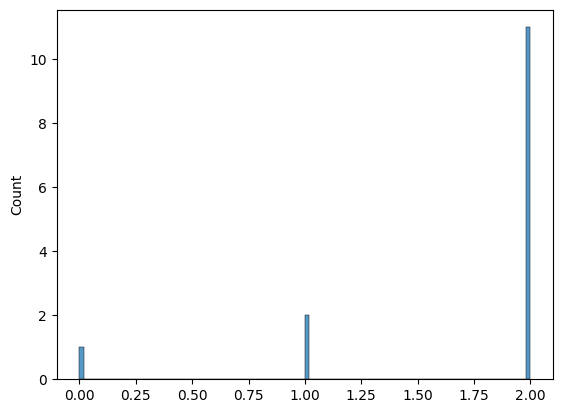

In [48]:
traj_collection.histogram_traj_length()

In [ ]:
# for track_id, traj in traj_collection:
#     print("track_id=", track_id)
#     traj.timeframe_to_single_cell[list(traj.timeframe_to_single_cell.keys())[0]].show_panel(figsize=(20, 5))
#     plt.show()
    

In [50]:
%gui qt
from livecell_tracker.core.napari_visualizer import NapariVisualizer
import napari
from skimage import data


In [51]:
from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
import numpy as np
from napari.viewer import Viewer
from livecell_tracker.core.visualizer import Visualizer

from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
import numpy as np
from napari.viewer import Viewer
from livecell_tracker.core.visualizer import Visualizer


# viewer = napari.view_image(dic_dataset.to_dask(), name='dic_image', cache=True)
# shape_layer = NapariVisualizer.viz_trajectories(traj_collection, viewer, contour_sample_num=20)

### Manually or programmatically correct trajectories via SCTOperator

In [52]:
import napari
from livecell_tracker.core.sct_operator import SctOperator, create_sct_napari_ui
viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
shape_layer = NapariVisualizer.gen_trajectories_shapes(traj_collection, viewer, contour_sample_num=20)
shape_layer.mode = "select"

In [53]:

sct_operator = SctOperator(traj_collection, shape_layer, viewer)
# sct_operator.setup_shape_layer(shape_layer)
create_sct_napari_ui(sct_operator)

RuntimeError: wrapped C/C++ object of type _QtMainWindow has been deleted

In [54]:
sct_operator.select_info

[]

In [55]:
sct_operator.select_shape(None)

current shape layer shape properties:  None
No shape selected, please select a shape to connect trajectories


Manually call methods of sct_operator to connect/disconnect/add relations

In [ ]:
# sct_operator.connect_two_scts()
# sct_operator.disconnect_sct()
# sct_operator.add_mother_daughter_relation()

Delete something in Napari and run the following block for multiple times to observe if the corresponding keys have been deleted from the trajectory collection

In [56]:
sct_operator.traj_collection.track_id_to_trajectory.keys()

dict_keys([13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 14.0])